# Imports

In [1]:
import PIL.Image as Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import torchvision
import torch
import numpy as np

# Utils

In [38]:
def get_image(path):
    img = Image.open(path) # Load the image
    transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
    return img

def show_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(img.permute(1,2,0))
    plt.title("Rue Cremieux")
    plt.show()
    
def save_mask(data,file):
    cmap = plt.cm.gray
    norm = plt.Normalize(vmin=data.min(), vmax=data.max())
    mask = cmap(norm(data))
    plt.imsave(file, mask)
    
def save_edit(data,file):      
    edit = T.ToPILImage(mode='RGB')(data)
    edit.save(file)

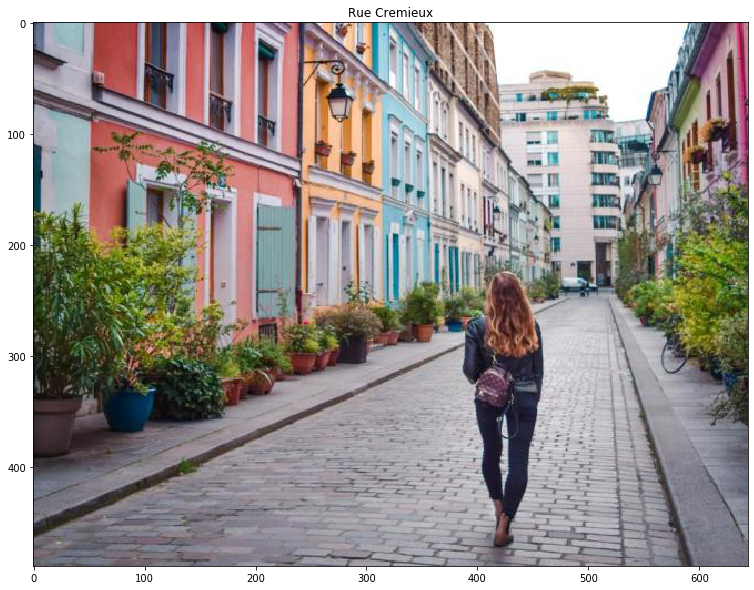

In [39]:
img=get_image('./rue_cremieux.jpg')
show_image(img)

#  Segmentation

## Segmentation with boxes

In [4]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval();

In [5]:
pred = model([img]) # Pass the image to the model

In [6]:
mask=torch.zeros(img.shape[1:3])
image_edit_box=img.clone().detach()
pred[0]['boxes'][0]
for canal in range(3):
    for row in range(int(pred[0]['boxes'][0][0]),int(pred[0]['boxes'][0][2])):
        for column in range(int(pred[0]['boxes'][0][1]),int(pred[0]['boxes'][0][3])):
            image_edit_box[canal,column,row]=0.6
            mask[column,row]=1
save_edit(image_edit_box,'image_edit_box.png')

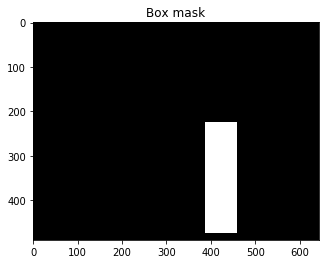

In [7]:
plt.imshow(mask,cmap='gray')
plt.title('Box mask')
plt.show()
save_mask(mask,'box_mask.png')

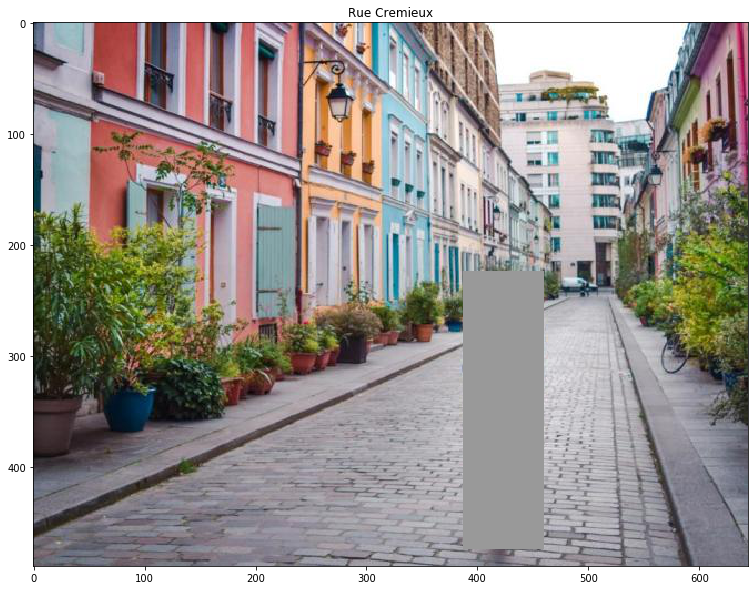

In [8]:
show_image(image_edit_box)

## Pixelwise segmentation

In [9]:
model2 = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model2.eval();

In [10]:
def get_mask(img, model, mask_threshhold=0.2, label_threshhold =0.9):
    pred = model(img.unsqueeze(0)) 
    scores = pred[0]['scores']
    labels = pred[0]['labels']
    masks = pred[0]['masks']

    final_mask=np.zeros(shape = (img.shape[1], img.shape[2]))
    for s, l, m in zip(scores, labels, masks):
        if l == 1 and s >= label_threshhold:
            final_mask[m.detach().numpy()[0] > mask_threshhold] = 1

    return final_mask

In [11]:
final_mask = get_mask(img, model2)

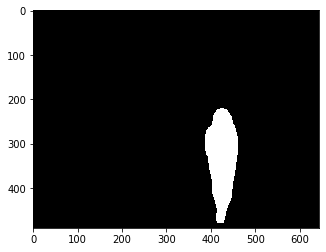

In [12]:
plt.imshow(final_mask, cmap='gray');
save_mask(final_mask,'pixelwise_mask.png')

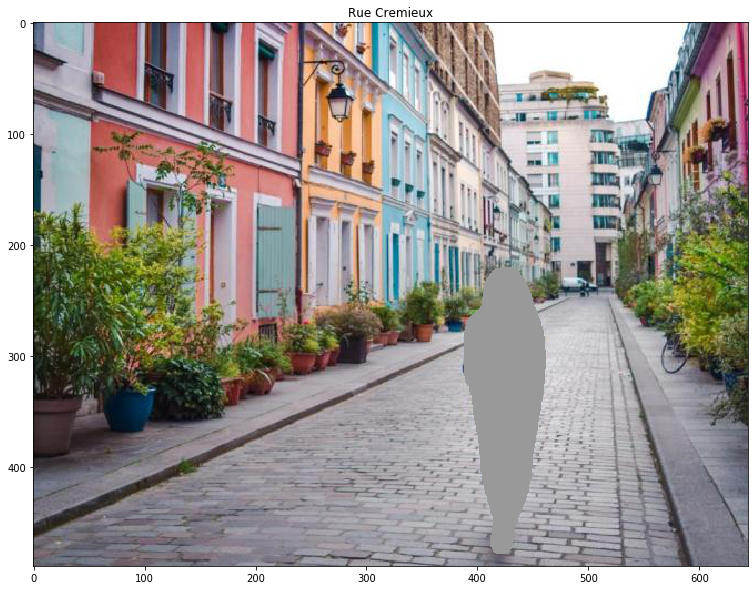

In [13]:
image_edit_pixelwise = img.clone().detach()
image_edit_pixelwise = image_edit_pixelwise.permute(1, 2, 0)
for canal in range(3):
    image_edit_pixelwise[:, :, canal][final_mask.astype(bool)] = 0.6
image_edit_pixelwise = image_edit_pixelwise.permute(2, 0, 1)
save_edit(image_edit_pixelwise, 'SinGAN/Input/Editing/image_edit_segmentation.png')
show_image(image_edit_pixelwise)

## Naive filling

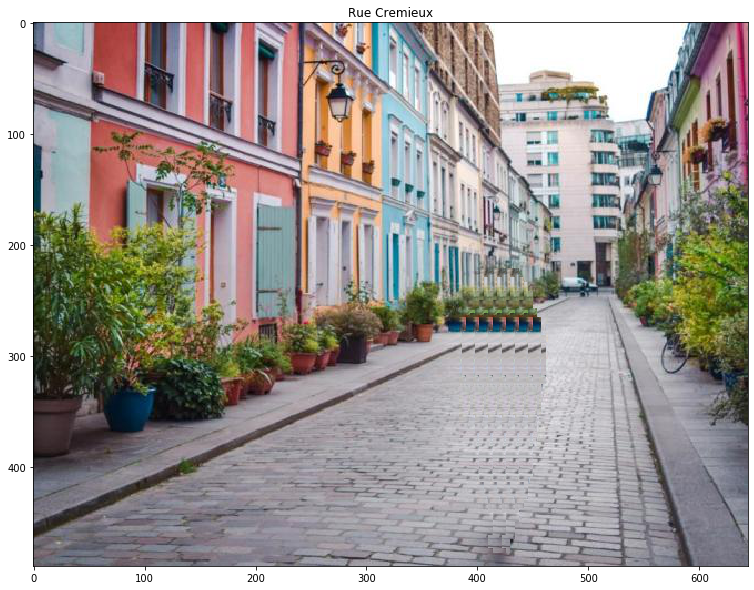

In [14]:
pas=2
shift=-12

image_edit_clever_pixelwise=img.clone().detach()
for row in range(0,image_edit_clever_pixelwise.shape[1],2*pas):
    for column in range(0,image_edit_clever_pixelwise.shape[2],2*pas):
        if final_mask[row,column]==True:
            image_edit_clever_pixelwise[:,row-pas:row+pas,column-pas:column+pas]=image_edit_clever_pixelwise[:,row-pas:row+pas,column-pas+shift:column+pas+shift]
            
show_image(image_edit_clever_pixelwise)
save_edit(image_edit_clever_pixelwise,'image_edit_clever_pixelwise.png')


## Patch based filling

In [15]:
def erode(mask,kernel_size):
    eroded_mask=mask.copy()
    for i in range(kernel_size,mask.shape[0]-kernel_size):
        for j in range(kernel_size,mask.shape[1]-kernel_size):
            eroded_mask[i,j]=(mask[i-kernel_size:i+kernel_size+1,j-kernel_size:j+kernel_size+1]).min()
    return eroded_mask

In [16]:
def dilate(mask,kernel_size):
    dilated_mask=mask.copy()
    for i in range(kernel_size,mask.shape[0]-kernel_size):
        for j in range(kernel_size,mask.shape[1]-kernel_size):
            dilated_mask[i,j]=(mask[i-kernel_size:i+kernel_size+1,j-kernel_size:j+kernel_size+1]).max()
    return dilated_mask

In [17]:
def get_border(mask,kernel_size):
    """ Borders of a mask can be obtained with a substraction between a mask and the eroded_mask 
    Size of border can be tune with the kernel size of the erosion"""
    
    eroded_mask=erode(mask,kernel_size)
    return mask-eroded_mask #bitwise XOR between mask and eroded_mask

In [18]:
def roam(mask,border):
    "We suppose that the mask is convex"
    
    #get the indices of pixels on the border
    pixels_to_visit= np.where(border == 1)
    pixels_to_visit=tuple(zip(*pixels_to_visit))  #not in the right order
    
    #get the coordinates of the centroid
    count = (mask == 1).sum()
    x_center, y_center = np.argwhere(mask==1).sum(0)/count
    barycentre=[x_center,y_center]
    
    #compute the angle with respect to the centroid
    sort_angle = lambda x: np.arctan2(x[0]-barycentre[0], x[1]-barycentre[1])
    
    #Final sort
    pixels_to_visit=sorted(pixels_to_visit,key = sort_angle)

    return pixels_to_visit
    

In [19]:
def closest_patch(img,xc,yc,rSearch,rPatch,mask):
    
    patch=img[:,xc-rPatch:xc+rPatch , yc-rPatch:yc+rPatch+1]
    patch_mask=1-mask[xc-rPatch:xc+rPatch , yc-rPatch:yc+rPatch+1] #represent valid pixels
    
    best_dist=float("inf")
    best_x,best_y= None,None
    best_patch=patch
    
    for i in range(xc-rSearch,xc+rSearch):     #step in x and y axis is rPatch
        for j in range(yc-rSearch,yc+rSearch):  
            if rPatch<i<img.shape[1]-rPatch and rPatch<j<img.shape[2]-rPatch:  # if cur_patch is inside the image
                
                cur_patch_mask=mask[i-rPatch:i+rPatch,j-rPatch:j+rPatch+1]
                cur_patch=img[:,i-rPatch:i+rPatch,j-rPatch:j+rPatch+1]
                cur_dist=(((patch-cur_patch)**2)*patch_mask).mean()        # take into account the distance over the patch

                if cur_dist<best_dist and cur_patch_mask.sum()==0: #meilleur match+ en dehors du mask
                    best_dist=cur_dist
                    best_x,best_y=i,j
                    best_patch=cur_patch
   
    assert best_x is not None, "no matched patch found"
    return patch,best_patch

In [20]:
def fill_mask(img,mask,rSearch,rPatch):
    
    #copy inputs
    edit=img.clone().detach()
    prog_mask=mask.copy()
    
    #While the mask is not null
    while prog_mask.sum()!=0:
        print("number of pixels still in the mask: {}".format(int(prog_mask.sum())))   
        border=get_border(prog_mask,1)
        
        pixels_to_visit=roam(prog_mask,border)
        pixels_to_visit=pixels_to_visit[::rPatch]    #takes one pixel out of rPatch
        
        for pixel in pixels_to_visit:
            _,match=closest_patch(edit,pixel[0],pixel[1],rSearch,rPatch,prog_mask)
            edit[:,pixel[0]-rPatch:pixel[0]+rPatch,pixel[1]-rPatch:pixel[1]+rPatch+1]=match
        
        prog_mask=erode(prog_mask,rPatch)   #erode the mask
        
    return edit
                

In [21]:
edit=fill_mask(img,final_mask,12,2)

number of pixels still in the mask: 12777
number of pixels still in the mask: 11457
number of pixels still in the mask: 10169
number of pixels still in the mask: 8918
number of pixels still in the mask: 7709
number of pixels still in the mask: 6566
number of pixels still in the mask: 5541
number of pixels still in the mask: 4585
number of pixels still in the mask: 3701
number of pixels still in the mask: 2879
number of pixels still in the mask: 2134
number of pixels still in the mask: 1482
number of pixels still in the mask: 962
number of pixels still in the mask: 579
number of pixels still in the mask: 290
number of pixels still in the mask: 94


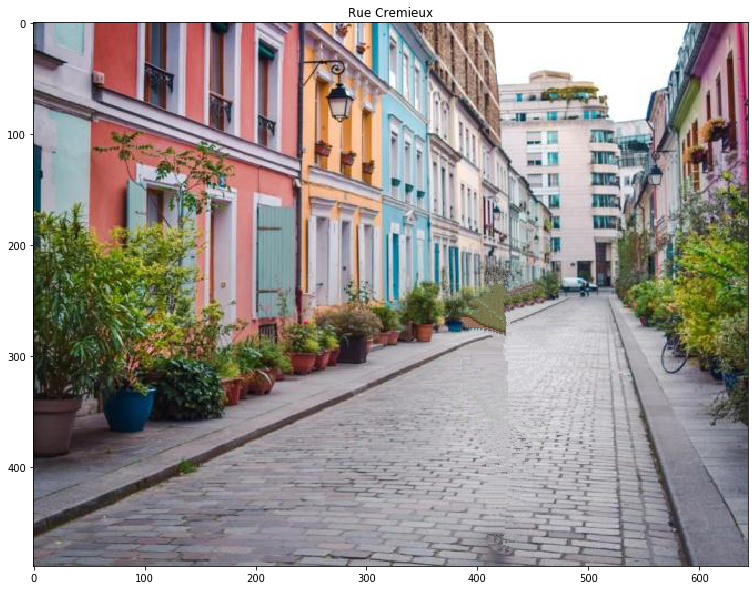

In [22]:
show_image(edit)

In [23]:
save_edit(edit,'best_edit.png')

# Visualisation of the method

## Borders at the different steps

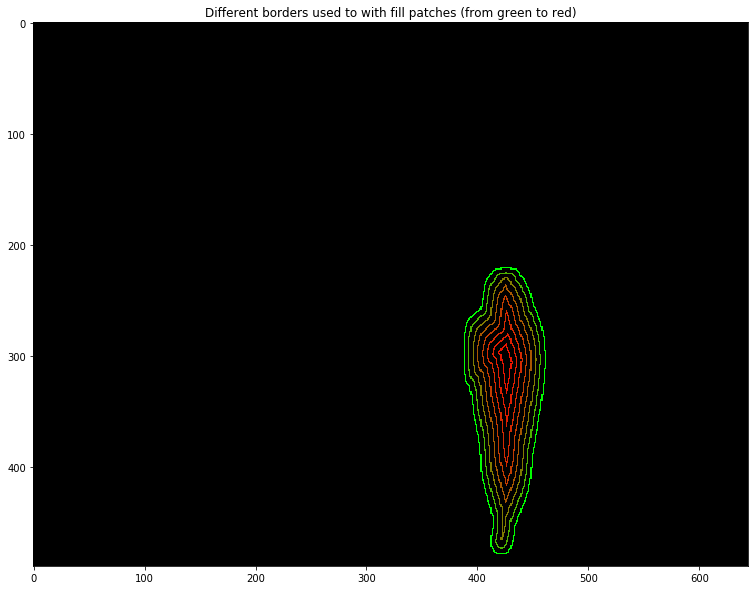

In [71]:
idx=1

evolution_mask=final_mask.copy()
border=get_border(evolution_mask,1)
full_border=np.zeros((img.shape[1],img.shape[2],img.shape[0]))

full_border[:,:,0]=(1-idx)*border
full_border[:,:,1]=idx*border

#While the mask is not null
while evolution_mask.sum()!=0:
    idx*=0.7
    
    evolution_mask=erode(evolution_mask,4)
    border=get_border(evolution_mask,1)
    full_border[:,:,0]+=(1-idx)*border
    full_border[:,:,1]+=idx*border

plt.figure(figsize=(20,10))
plt.imshow(full_border)
plt.title("Different borders used to with fill patches (from green to red)")
plt.show()


## Roam a specific border

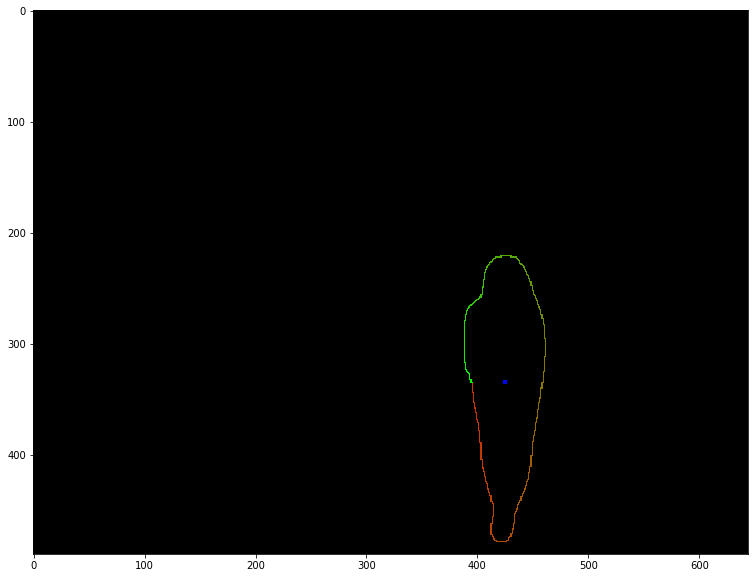

In [76]:
idx=1
order=np.zeros((img.shape[1],img.shape[2],img.shape[0]))

border=get_border(final_mask,1)
pixels_to_visit=roam(final_mask,border)

#Show order
for i in range(len(pixels_to_visit)):
    order[pixels_to_visit[i][0],pixels_to_visit[i][1],0]=1-idx
    order[pixels_to_visit[i][0],pixels_to_visit[i][1],1]=idx
    
    idx*=0.9975

#Show centroid
count = (final_mask == 1).sum()
x_center, y_center = np.argwhere(final_mask==1).sum(0)/count
order[int(x_center)-2:int(x_center)+2,int(y_center)-2:int(y_center)+2,2]=1

plt.figure(figsize=(20,10))
plt.imshow(order)
plt.title("Travel order on the contour (from green to red)/ Centroid (blue)")
plt.show()
